In [1]:
import os
import numpy as np
import torch
import cv2
from torch.utils.data import DataLoader
import sys
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.optimize import linear_sum_assignment
from collections import Counter
from scipy.signal import argrelextrema
from scipy.special import factorial

# Get the path of the project root
project_root = os.path.abspath(os.path.join(os.path.dirname('__file__'), '..'))

# Add the project root to sys.path if it is not already in sys.path
if project_root not in sys.path:
    sys.path.append(project_root)

# Import the ImageSequenceDataset and create_dataloader from the pipeline module
from seismogram_extraction.pipeline import evaluate_filter, create_dataloader
from seismogram_extraction.filters.hungarian_extended_kalman_filter import HungarianExtendedKalmanFilter

import torch.multiprocessing as mp
mp.set_start_method('spawn')  # or 'forkserver' if available

from collections import defaultdict

plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['ytick.labelsize'] = 11
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.grid'] = True
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['legend.loc'] = 'upper right'
plt.rcParams['axes.titlesize'] = 12

# Load the seismogram

In [2]:
# Paths to your files
image_path = r"D:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\data\raw\UCC19540112Gal_E_0750_binary.jpg"

# Load image as grayscale and convert to float32
image_source = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE).astype(np.float32)
image_source = image_source.astype(np.float32) / 255.0  # Normalize to [0, 1]
image_source = image_source.max() - image_source  # Invert the image

# crop
image_source = image_source[:, 1000:1290]

# Confirm shapes
print("Image shape:", image_source.shape)   # (height, width)

Image shape: (2849, 290)


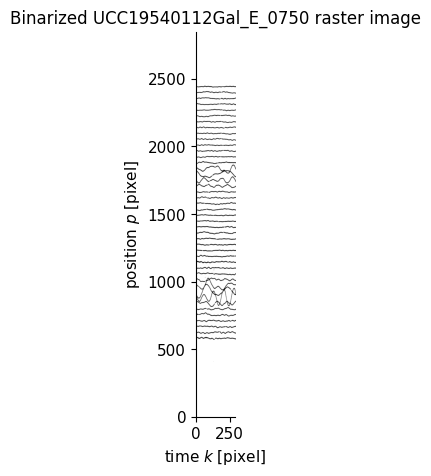

In [3]:
# First figure: imshow
plt.figure(figsize=(12, 5))
plt.imshow(image_source.max()-image_source, cmap='gray', origin='lower')
plt.xlabel(r"time $k$ [pixel]")
plt.ylabel(r"position $p$ [pixel]")
plt.title("Binarized UCC19540112Gal_E_0750 raster image")
plt.grid(False)

# Ensure the output folder exists
output_folder_path = os.path.join(os.getcwd(), "output")
os.makedirs(output_folder_path, exist_ok=True)

# Save the figure
plt.savefig(os.path.join(output_folder_path, f"UCC19540112Gal_E_0750_binary.jpg"), bbox_inches='tight', dpi=300)
plt.show()

# Second figure: scatter-only pixel representation
# plt.figure(figsize=(12, 5))
# for k in range(len(gt[0])):
#     col = np.where(image[:, k] > 0.5)[0]
#     if len(col) > 0:
#         plt.scatter(k*np.ones_like(col), col, s=1, color='red', alpha=0.6)  
# plt.title("Pixel Discretization of Ground Truth Traces (scatter only)")
# plt.xlabel("k (time)")
# plt.ylabel("p (position)")
# plt.grid(True)
# plt.show()


## Get Region Of Interest

Threshold1: 100.55592346191406
Threshold2: 16.138824462890618


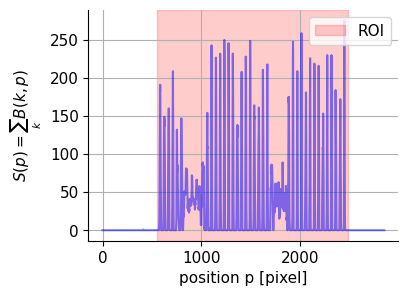

In [4]:
def get_roi(image, threshold = 100):
    """
    Extract the region of interest from an image based on row sum threshold.

    Parameters:
    - image (np.ndarray): 2D or 3D grayscale image array.
    - threshold (int): Minimum row sum to consider as part of the ROI.

    Returns:
    - roi (np.ndarray): Cropped image containing only the rows in the ROI.
    - start_row (int): Index of the first row included in the ROI.
    - end_row (int): Index of the last row (exclusive) in the ROI.
    """
    sum_rows = image.sum(axis=1)
    indices = np.where(sum_rows > threshold)[0]

    if len(indices) == 0:
        print("No rows exceed the threshold.")
        return image[0:1], 0, 1  # dummy ROI and bounds

    start_row = max(int(indices[0] - 0.01 * image.shape[0]), 0)
    end_row = min(int(indices[-1] + 0.01 * image.shape[0]), image.shape[0])

    roi = image[start_row:end_row]
    return roi, start_row, end_row

sum_rows = image_source.sum(axis=1)

plt.figure(figsize=(4, 3))
plt.plot(sum_rows, color='blue', alpha=0.5)
plt.xlabel("position p [pixel]")
plt.ylabel(r"$S(p) = \sum_k B(k, p)$")
plt.grid(True)

# Thresholds
k = 1.5
threshold1 = np.mean(sum_rows) + k * np.std(sum_rows)
print("Threshold1:", threshold1)

threshold2 = np.percentile(sum_rows, 70)
print("Threshold2:", threshold2)

# Get region of interest using one of the thresholds
image, start_row, end_row = get_roi(image_source, threshold=int(threshold2))

# Highlight ROI with vertical bars
plt.axvspan(start_row, end_row, color='red', alpha=0.2, label='ROI')
plt.legend()

# Ensure the output folder exists
output_folder_path = os.path.join(os.getcwd(), "output")
os.makedirs(output_folder_path, exist_ok=True)

# Save the figure
plt.savefig(os.path.join(output_folder_path, f"get_roi.pdf"), format="pdf", bbox_inches='tight', dpi=300)

plt.show()

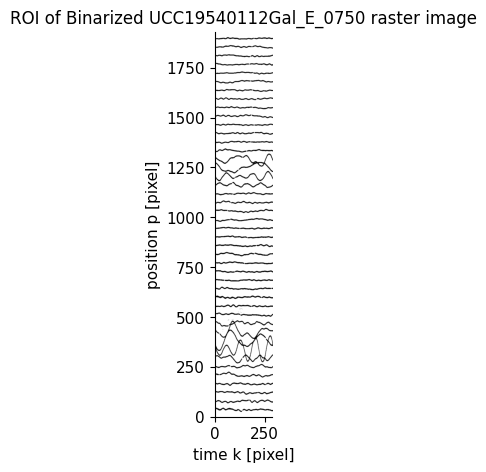

In [5]:
# First figure: imshow
plt.figure(figsize=(12, 5))
plt.imshow(image.max()-image, cmap='gray', origin='lower')
plt.xlabel("time k [pixel]")
plt.ylabel("position p [pixel]")
plt.title("ROI of Binarized UCC19540112Gal_E_0750 raster image")
plt.grid(False)

# Ensure the output folder exists
output_folder_path = os.path.join(os.getcwd(), "output")
os.makedirs(output_folder_path, exist_ok=True)

# Save the figure
plt.savefig(os.path.join(output_folder_path, f"UCC19540112Gal_E_0750_binary_roi.jpg"), bbox_inches='tight', dpi=300)
plt.show()

# Get number of components and average thickness

In [6]:
def count_components_and_avg_thickness(arr, threshold=0.5):
    """
    Counts the number of connected components where values are close to 1 
    and computes the average thickness.

    Parameters:
    - arr: 1D numpy array containing binary values (0 for background, 1 for foreground).
    - threshold: Defines what is considered "foreground" (default: 0.5 for binary).

    Returns:
    - count: Number of connected components (foreground regions).
    - avg_thickness: Average thickness (length) of those components.
    """
    count = 0
    thicknesses = []
    n = len(arr)
    
    i = 0
    while i < n:
        if arr[i] > threshold:  # Found a new foreground component
            count += 1
            start = i
            while i < n and arr[i] > threshold:
                i += 1
            thicknesses.append(i - start)
        else:
            i += 1

    avg_thickness = np.mean(thicknesses) if thicknesses else 0
    return count, avg_thickness

# apply to the columns of the image and compute the average thickness, average number of components
N_components = []
thickness = []

for i in range(image.shape[1]):
    n, t = count_components_and_avg_thickness(image[:, i])
    N_components.append(n)
    thickness.append(t)

# compute the average thickness and number of components for the image by ignoring the columns with no components
N_components = np.array(N_components)
thickness = np.array(thickness)
N_components = N_components[N_components > 0.9]
thickness = thickness[thickness > 0.9]

def most_common_component_count(N_components):
    """
    Returns the most frequently occurring value in the list of component counts.
    If there's a tie, returns the smallest one.
    """
    counter = Counter(N_components)
    print(counter)
    most_common = counter.most_common(1)[0][0]  # (value, frequency)
    return most_common

# Example usage
most_N_components = most_common_component_count(N_components)
print("Most common component count:", most_N_components)

median_N_components = int(np.round(np.median(N_components)))
print(f"Median number of components: {median_N_components}")
avg_N_components = 44 #int(np.round(np.mean(N_components)))
avg_thickness = int(np.round(np.mean(thickness)))
print(f"Average number of components: {avg_N_components} VS true value is 44")
print(f"Average thickness: {avg_thickness}")

Counter({44: 141, 43: 94, 42: 28, 45: 12, 41: 9, 46: 3, 40: 2, 39: 1})
Most common component count: 44
Median number of components: 44
Average number of components: 44 VS true value is 44
Average thickness: 6


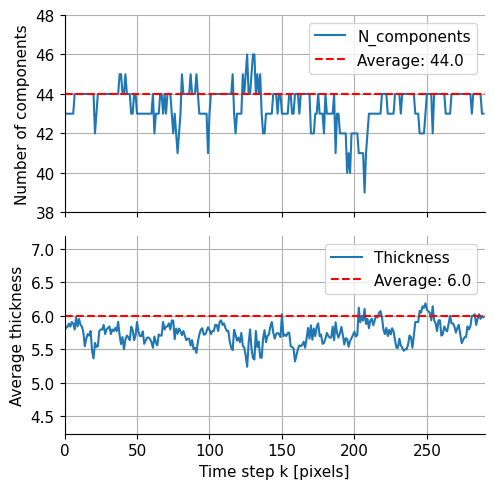

In [7]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 5), sharex=True)

# --- Top subplot: Number of components ---
ax1.plot(N_components, label="N_components")
ax1.axhline(y=avg_N_components, color='r', linestyle='--', label=f"Average: {avg_N_components:.1f}")
ax1.set_xlim(0, image.shape[1])
ax1.set_ylim(38, 48)
ax1.set_ylabel("Number of components")
ax1.legend()
ax1.grid(True)

# --- Bottom subplot: Average thickness ---
ax2.plot(thickness, label="Thickness")
ax2.axhline(y=avg_thickness, color='r', linestyle='--', label=f"Average: {avg_thickness:.1f}")
ax2.set_xlim(0, image.shape[1])
ax2.set_ylim(np.min(thickness)-1, np.max(thickness)+1)
ax2.set_xlabel("Time step k [pixels]")
ax2.set_ylabel("Average thickness")
ax2.legend()
ax2.grid(True)

# Tight layout for aesthetics
plt.tight_layout()

# Ensure the output folder exists
output_folder_path = os.path.join(os.getcwd(), "output")
os.makedirs(output_folder_path, exist_ok=True)

# Save the figure
plt.savefig(os.path.join(output_folder_path, f"N_com_thickness.pdf"), format="pdf", bbox_inches='tight', dpi=300)
plt.show()

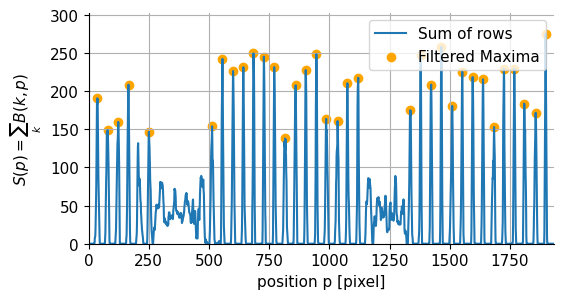

In [8]:

# Step 1: Sum the rows
sum_rows = np.sum(image, axis=1)
plt

# Step 2: Find local maxima
max_indices = argrelextrema(sum_rows, np.greater, order=10)[0]

# Step 3: Sort maxima by peak height (descending)
sorted_max = max_indices[np.argsort(sum_rows[max_indices])[::-1]]

# Step 4: Keep only top N
top_max = sorted_max[:avg_N_components]

# Step 5: Filter out those lower than half the max peak value
peak_values = sum_rows[top_max]
max_peak_value = np.max(peak_values)
threshold_value = 0.5 * max_peak_value

filtered_max = top_max[peak_values >= threshold_value]

# Step 6: Plot
plt.figure(figsize=(6, 3))
plt.plot(sum_rows, label="Sum of rows")
plt.scatter(filtered_max, sum_rows[filtered_max], color='orange', label="Filtered Maxima")
plt.xlim(0, image.shape[0])
plt.ylim(0, np.max(sum_rows) + 0.1 * np.max(sum_rows))
plt.xlabel("position p [pixel]")
plt.ylabel(r"$S(p) = \sum_k B(k, p)$")
plt.grid(True)

plt.legend()

# Ensure the output folder exists
output_folder_path = os.path.join(os.getcwd(), "output")
os.makedirs(output_folder_path, exist_ok=True)

# Save the figure
plt.savefig(os.path.join(output_folder_path, f"filtered_max.pdf"), format="pdf", bbox_inches='tight', dpi=300)
plt.show()


Average spacing between meanlines: 44.645161290322584


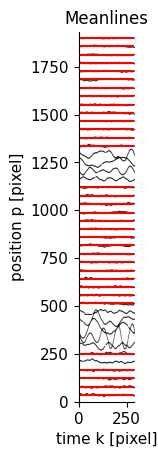

In [9]:
# The meanlines are the num_components rows with the minimum sum

def mean_ignoring_outliers_std(arr, k=2):
    arr = np.array(arr)
    mean = np.mean(arr)
    std = np.std(arr)
    filtered = arr[np.abs(arr - mean) <= k * std]
    return np.mean(filtered)

meanlines = np.sort(filtered_max[:avg_N_components])
spaces = np.diff(meanlines)
spacing = mean_ignoring_outliers_std(spaces, k=1.5)

print("Average spacing between meanlines:", spacing)

plt.imshow(image.max() - image, cmap='gray', origin='lower')
for meanline in meanlines:
    plt.axhline(meanline, color='r')
plt.title("Meanlines")
plt.xlabel("time k [pixel]")
plt.ylabel("position p [pixel]")
plt.grid(False)

# Ensure the output folder exists
output_folder_path = os.path.join(os.getcwd(), "output")
os.makedirs(output_folder_path, exist_ok=True)

# Save the figure
plt.savefig(os.path.join(output_folder_path, f"UCC19540112Gal_E_0750_meanlines.jpg"), bbox_inches='tight', dpi=300)
plt.show()

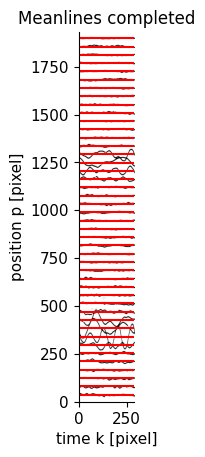

In [10]:
meanlines = np.linspace(meanlines[0], meanlines[-1], avg_N_components)

plt.imshow(image.max() - image, cmap='gray', origin='lower')
for meanline in meanlines:
    plt.axhline(meanline, color='r')
plt.title("Meanlines completed")
plt.xlabel("time k [pixel]")
plt.ylabel("position p [pixel]")
plt.grid(False)

# Ensure the output folder exists
output_folder_path = os.path.join(os.getcwd(), "output")
os.makedirs(output_folder_path, exist_ok=True)

# Save the figure
plt.savefig(os.path.join(output_folder_path, f"UCC19540112Gal_E_0750_all_meanlines.jpg"), bbox_inches='tight', dpi=300)
plt.show()

# Extract the curves ($\omega$ constant)

In [11]:
def function_f(x, dt):
    """ Non-linear state transition function for a sine-like model."""
    x_next =np.zeros_like(x, dtype=np.float64)
    x_next[0] = x[0] + x[1]*dt  # position
    x_next[1] = x[1] - x[2]**2*dt/2 * (2*x[0]+dt*x[1]-2*x[3])  # velocity
    x_next[2] = x[2]  # frequency
    x_next[3] = x[3]  # offset
    return x_next

def build_A_matrix(x, dt):
    """Build state linearized transition matrix A for a sine-like model."""
    # Prevent extreme values from exploding Jacobian
    # w = np.clip(w, 1e-5, 10)
    # p = np.clip(p, -1e5, 1e5)
    # b = np.clip(b, -1e5, 1e5)
    A = np.zeros((len(x), len(x)), dtype=np.float64)
    A[0, 0] = 1
    A[0, 1] = dt
    A[1, 0] = -dt * x[2]**2
    A[1, 1] = 1 - dt**2 * x[2]**2 / 2
    A[1, 2] = - dt * x[2] * (2 * x[0] + dt * x[1] - 2 * x[3])
    A[1, 3] = dt * x[2]**2
    A[2, 2] = 1
    A[3, 3] = 1

    # A = np.clip(A, -1e3, 1e3)  # Prevent extreme values from exploding Jacobian
    return A

def build_Q_matrix(dt, q, sigma_w):
    """
    Build process noise covariance matrix Q for the state [p, p_dot, omega, b].

    - q: spectral density of white acceleration noise (for [p, p_dot] block)
    - sigma_w: variance of frequency noise (for omega random walk)
    - sigma_b: variance of offset noise (for b random walk)
    """
    Q = np.zeros((4, 4), dtype=np.float64)

    # Correct continuous white-acceleration model for [p, p_dot]
    Q[0, 0] = q * dt**3 / 3
    Q[0, 1] = q * dt**2 / 2
    Q[1, 0] = q * dt**2 / 2
    Q[1, 1] = q * dt

    # Independent white noise for omega and b
    Q[2, 2] = sigma_w**2

    return Q

def build_P_matrix(num_traces, sigma_p, sigma_v, sigma_w):
    """Build initial state covariance matrix P with increasing uncertainty."""
    P_patern = np.array([[sigma_p**2, 0, 0, 0],
                         [0, sigma_v**2, 0, 0],
                         [0, 0, sigma_w**2, 0],
                         [0, 0, 0, 0]])
    P = np.array([np.copy(P_patern) for _ in range(num_traces)])
    return P

Processing columns: 100%|██████████| 289/289 [00:01<00:00, 188.48it/s]


Text(0.5, 0, 'Time step')

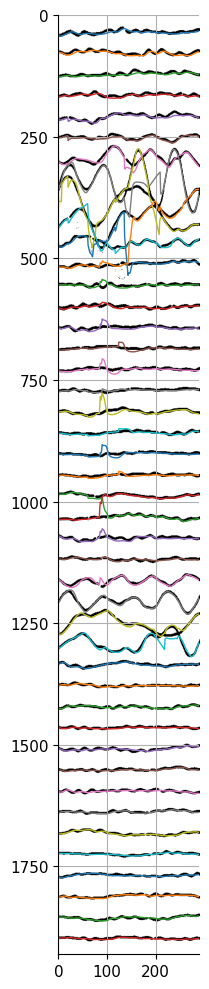

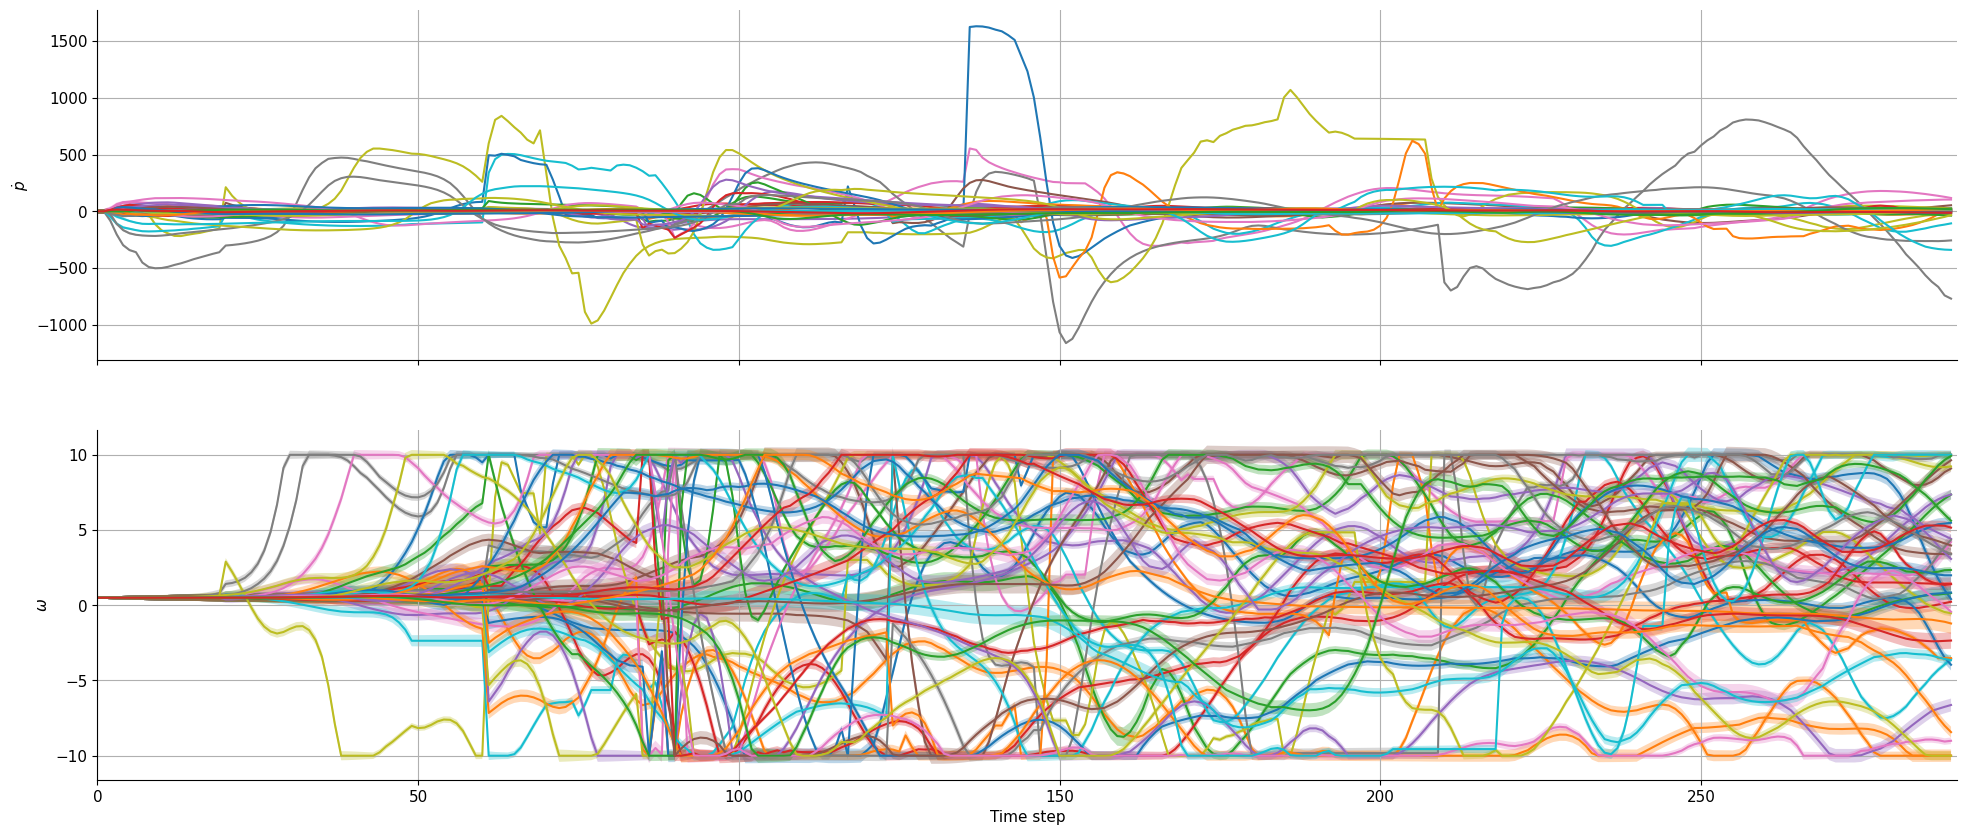

In [12]:
Dt = 0.007 # second (number of second per pixel)

q = 1e-1
sigma_omega = 0.0526

sigma_z = np.sqrt(5e-2) # pixels unit

sigma_p_0 = 10 # pixels unit
sigma_v_0 = 20 # pixels unit / second
sigma_omega_0 = 0.0526
omega_0 = 0.5

Q = build_Q_matrix(Dt, q, sigma_omega)
P_0 = build_P_matrix(avg_N_components, sigma_p_0, sigma_v_0, sigma_omega_0)
H = np.zeros((1, 4), dtype=np.float64)
H[0, 0] = 1
R = np.array([[sigma_z**2]], dtype=np.float64)

HEKF = HungarianExtendedKalmanFilter(H, Q, R, Dt, function_f, build_A_matrix)

X_0 = np.zeros((avg_N_components, H.shape[-1]))
X_0[:, 0] = meanlines
X_0[:, 2] = omega_0
X_0[:, 3] = meanlines

X_batch_pred, P_batch_pred = HungarianExtendedKalmanFilter.process_sequence(HEKF, image[np.newaxis][np.newaxis], X_0[np.newaxis], P_0[np.newaxis], step=1)

# plot
pred_positions = X_batch_pred[0, :, :, 0]
std_positions = np.sqrt(P_batch_pred[0,  :, :, 0, 0])

fig, ax = plt.subplots(figsize=(24, 10))
t_steps = np.arange(0, image.shape[-1])
ax.imshow(image.max() - image, cmap='gray')

for j in range(pred_positions.shape[1]):
    ax.plot(t_steps, pred_positions[:, j], label=f'Trace {j+1}', linewidth=1)
    ax.fill_between(t_steps,
                    pred_positions[:, j] - std_positions[:, j],
                    pred_positions[:, j] + std_positions[:, j],
                    alpha=0.15)

fig.tight_layout()
# Ensure the output folder exists
output_folder_path = os.path.join(os.getcwd(), "output")
os.makedirs(output_folder_path, exist_ok=True)

# Save the figure
fig.savefig(os.path.join(output_folder_path, f"UCC19540112Gal_E_0750_processed_w_cst.jpg"), bbox_inches='tight', dpi=300)

T = pred_positions.shape[0]
t = np.arange(T)
fig, axes = plt.subplots(2, 1, figsize=(24, 10), sharex=True)

labels = [r'$\dot{p}$', r'$\omega$']

for l in range(2):
    for j in range(avg_N_components):
        pred = X_batch_pred[0, :, :, l+1]
        std_pred = np.sqrt(P_batch_pred[0, :, :, l+1, l+1])

        axes[l].plot(t, pred[:, j], label=f'Trace {j+1}')
        axes[l].fill_between(t,
                            pred[:, j] - std_pred[:, j],
                            pred[:, j] + std_pred[:, j],
                            alpha=0.3)

    axes[l].set_xlim(0, T)
    # axes[l].legend(markerscale=5)
    axes[l].set_ylabel(labels[l])
axes[-1].set_xlabel('Time step')

# FORUM

In [13]:
def function_f(x, dt):
    """ Non-linear state transition function for a sine-like model."""
    x_next =np.zeros_like(x, dtype=np.float64)
    x_next[0] = x[0] + x[1]*dt  # position
    x_next[1] = x[1] - x[2]**2*dt/2 * (2*x[0]+dt*x[1]-2*x[-1])  # velocity
    x_next[2] = x[2]  # frequency
    x_next[3] = x[3] + dt * x[2]
    x_next[-1] = x[-1]  # offset
    return x_next

def build_A_matrix(x, dt):
    """Build state linearized transition matrix A for a sine-like model."""
    # Prevent extreme values from exploding Jacobian
    # w = np.clip(w, 1e-5, 10)
    # p = np.clip(p, -1e5, 1e5)
    # b = np.clip(b, -1e5, 1e5)
    A = np.zeros((len(x), len(x)), dtype=np.float64)
    A[0, 0] = 1
    A[0, 1] = dt
    A[1, 0] = -dt * x[2]**2
    A[1, 1] = 1 - dt**2 * x[2]**2 / 2
    A[1, 2] = - dt * x[2] * (2 * x[0] + dt * x[1] - 2 * x[4])
    A[1, 3] = 0
    A[1, 4] = dt * x[2]**2
    A[2, 2] = 1
    A[2, 3] = dt
    A[3, 3] = 1
    A[4, 4] = 1

    # A = np.clip(A, -1e3, 1e3)  # Prevent extreme values from exploding Jacobian
    return A

def build_Q_matrix(dt, q, sigma_p, sigma_w):
    """
    Build process noise covariance matrix Q for the state [p, p_dot, omega, b].

    - q: spectral density of white acceleration noise (for [p, p_dot] block)
    - sigma_w: variance of frequency noise (for omega random walk)
    - sigma_b: variance of offset noise (for b random walk)
    """
    Q = np.zeros((5, 5), dtype=np.float64)

    # Correct continuous white-acceleration model for [p, p_dot]
    Q[0, 0] = q * dt**3 / 3 * sigma_p**2
    Q[0, 1] = q * dt**2 / 2 * sigma_p**2
    Q[1, 0] = q * dt**2 / 2 * sigma_p**2
    Q[1, 1] = q * dt * sigma_p**2

    # Independent white noise for omega and b
    Q[2, 2] = q * dt**3 / 3 * sigma_w**2
    Q[2, 3] = q * dt**2 / 2 * sigma_w**2
    Q[3, 2] = q * dt**2 / 2 * sigma_w**2
    Q[3, 3] = q * dt * sigma_w**2
    return Q

def build_P_matrix(num_traces, sigma_p, sigma_v, sigma_w, sigma_phi):
    """Build initial state covariance matrix P with increasing uncertainty."""
    P_patern = np.array([[sigma_p**2, 0, 0, 0, 0],
                         [0, sigma_v**2, 0, 0, 0],
                         [0, 0, sigma_w**2, 0, 0],
                         [0, 0, 0, sigma_phi**2, 0],
                         [0, 0, 0, 0, 0]])
    P = np.array([np.copy(P_patern) for _ in range(num_traces)])
    return P

Processing columns: 100%|██████████| 289/289 [00:01<00:00, 171.90it/s]


Text(0.5, 0, 'Time step')

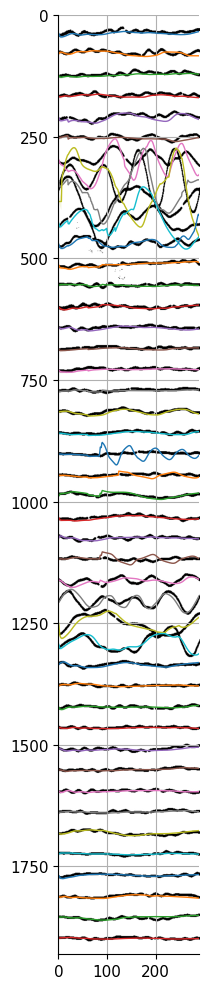

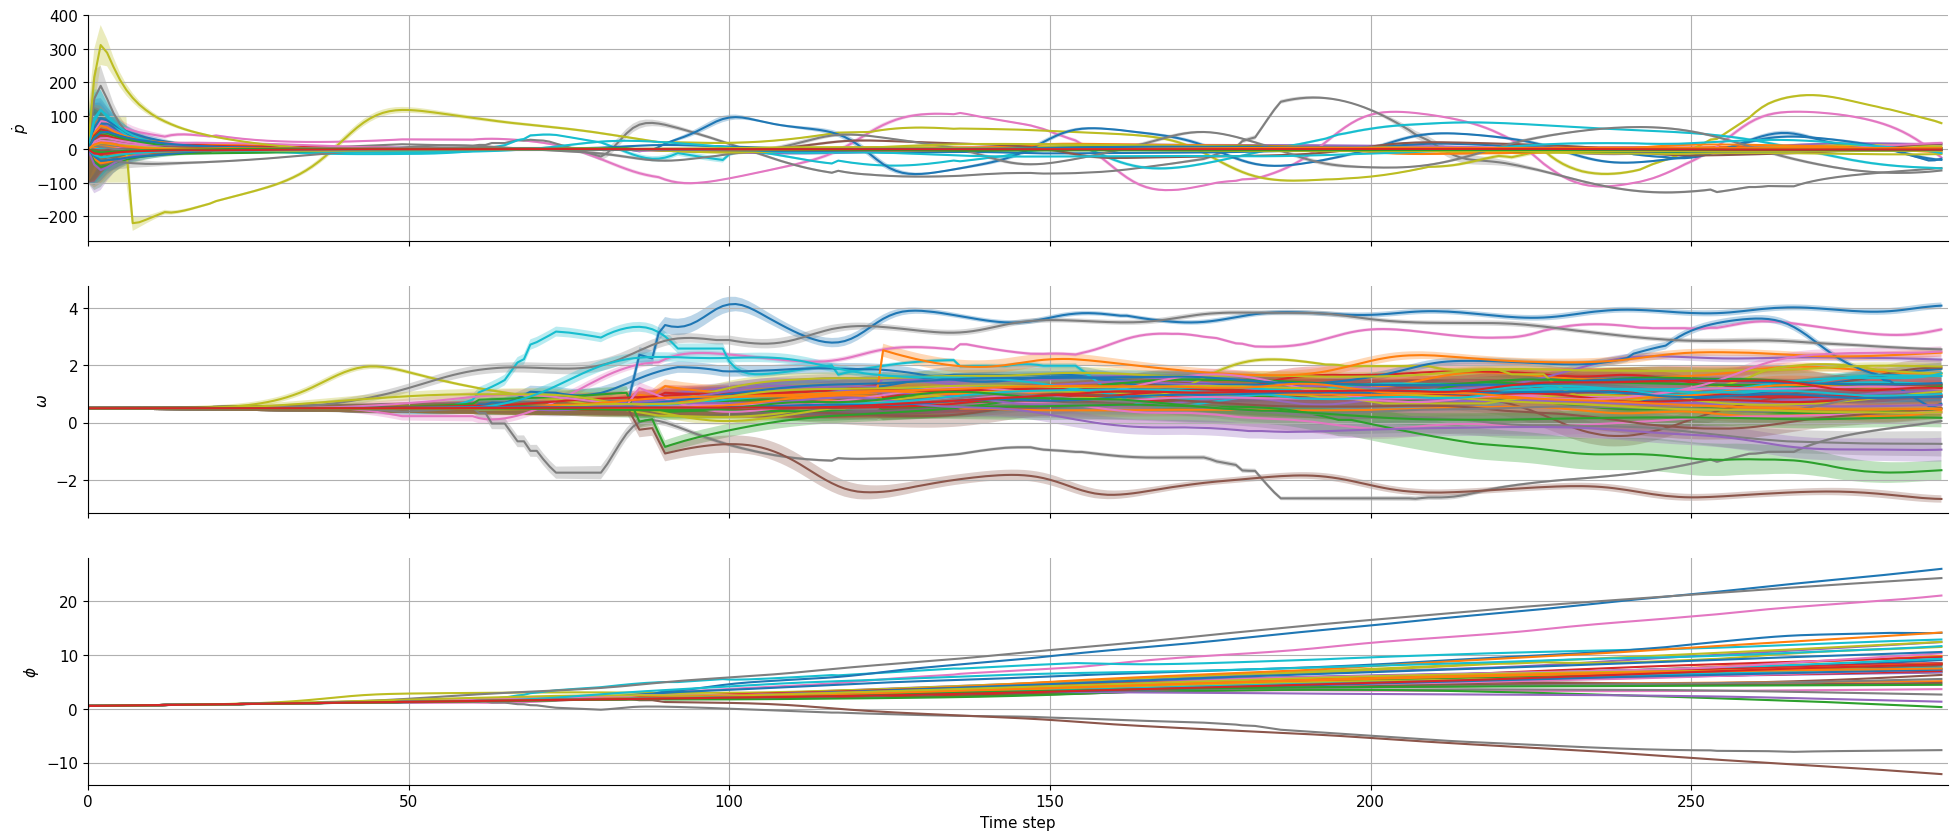

In [14]:
Dt = 0.03 # second (number of second per pixel)

q = 1e-3
sigma_p = 0.5
sigma_omega = 1

sigma_z = 5 # pixels unit

sigma_p_0 = 0 # pixels unit
sigma_v_0 = 100 # pixels unit / second
sigma_omega_0 = 0.0526
sigma_phi_0 = 0.1
omega_0 = 0.5
phi_0 = omega_0

Q = build_Q_matrix(Dt, q, sigma_p, sigma_omega)
P_0 = build_P_matrix(avg_N_components, sigma_p_0, sigma_v_0, sigma_omega_0, sigma_phi_0)
H = np.zeros((1, 5), dtype=np.float64)
H[0, 0] = 1
R = np.array([[sigma_z**2]], dtype=np.float64)

HEKF = HungarianExtendedKalmanFilter(H, Q, R, Dt, function_f, build_A_matrix)

X_0 = np.zeros((avg_N_components, H.shape[-1]))
X_0[:, 0] = meanlines
X_0[:, 2] = omega_0
X_0[:, 3] = phi_0
X_0[:, 4] = meanlines

X_batch_pred, P_batch_pred = HungarianExtendedKalmanFilter.process_sequence(HEKF, image[np.newaxis][np.newaxis], X_0[np.newaxis], P_0[np.newaxis], step=1)

# plot
pred_positions = X_batch_pred[0, :, :, 0]
std_positions = np.sqrt(P_batch_pred[0,  :, :, 0, 0])

fig, ax = plt.subplots(figsize=(24, 10))
t_steps = np.arange(0, image.shape[-1])
ax.imshow(image.max() - image, cmap='gray')

for j in range(pred_positions.shape[1]):
    ax.plot(t_steps, pred_positions[:, j], label=f'Trace {j+1}', linewidth=1)
    ax.fill_between(t_steps,
                    pred_positions[:, j] - std_positions[:, j],
                    pred_positions[:, j] + std_positions[:, j],
                    alpha=0.15)

fig.tight_layout()
# Ensure the output folder exists
output_folder_path = os.path.join(os.getcwd(), "output")
os.makedirs(output_folder_path, exist_ok=True)

# Save the figure
fig.savefig(os.path.join(output_folder_path, f"UCC19540112Gal_E_0750_processed_w_cst.jpg"), bbox_inches='tight', dpi=300)

T = pred_positions.shape[0]
t = np.arange(T)
fig, axes = plt.subplots(3, 1, figsize=(24, 10), sharex=True)

labels = [r'$\dot{p}$', r'$\omega$', r'$\phi$']

for l in range(3):
    for j in range(avg_N_components):
        pred = X_batch_pred[0, :, :, l+1]
        std_pred = np.sqrt(P_batch_pred[0, :, :, l+1, l+1])

        axes[l].plot(t, pred[:, j], label=f'Trace {j+1}')
        axes[l].fill_between(t,
                            pred[:, j] - std_pred[:, j],
                            pred[:, j] + std_pred[:, j],
                            alpha=0.3)

    axes[l].set_xlim(0, T)
    # axes[l].legend(markerscale=5)
    axes[l].set_ylabel(labels[l])
axes[-1].set_xlabel('Time step')

# Extract the curves ($\omega$ linear model)

In [13]:
def function_f(x, dt):
    """ Non-linear state transition function for a sine-like model."""
    x_next =np.zeros_like(x, dtype=np.float64)
    x_next[0] = x[0] + x[1]*dt  # position
    x_next[1] = x[1] - x[2]**2*dt/2 * (2*x[0]+dt*x[1]-2*x[4])  # velocity
    x_next[2] = x[2] + x[3]*dt  # angular frequency
    x_next[3] = x[3]  # angular frequency velocity
    x_next[4] = x[4]  # offset

    # clip angular frequency not to be negative
    x_next[2] = np.clip(x_next[2], 0, 1e5)
    return x_next

def build_A_matrix(x, dt):
    """Build state linearized transition matrix A for a sine-like model."""
    # Prevent extreme values from exploding Jacobian
    # w = np.clip(w, 1e-5, 10)
    # p = np.clip(p, -1e5, 1e5)
    # b = np.clip(b, -1e5, 1e5)
    A = np.zeros((len(x), len(x)), dtype=np.float64)
    A[0, 0] = 1
    A[0, 1] = dt
    A[1, 0] = -dt * x[2]**2
    A[1, 1] = 1 - dt**2 * x[2]**2 / 2
    A[1, 2] = - dt * x[2] * (2 * x[0] + dt * x[1] - 2 * x[4])
    A[1, 3] = 0
    A[1, 4] = dt * x[2]**2
    A[2, 2] = 1
    A[2, 3] = dt
    A[3, 3] = 1
    A[4, 4] = 1

    # A = np.clip(A, -1e3, 1e3)  # Prevent extreme values from exploding Jacobian
    return A

def build_Q_matrix(Dt, q_p, q_w):
    """
    Build process noise covariance matrix Q for the state [p, p_dot, omega, b].

    - q: spectral density of white acceleration noise (for [p, p_dot] block)
    - sigma_w: variance of frequency noise (for omega random walk)
    - sigma_b: variance of offset noise (for b random walk)
    """
    Q = np.zeros((5, 5), dtype=np.float64)

    # Correct continuous white-acceleration model for [p, p_dot]
    Q[0, 0] = q_p * Dt**3 / 3
    Q[0, 1] = q_p * Dt**2 / 2
    Q[1, 0] = q_p * Dt**2 / 2
    Q[1, 1] = q_p * Dt
    
    Q[2, 2] = q_w * Dt**3 / 3
    Q[2, 3] = q_w * Dt**2 / 2
    Q[3, 2] = q_w * Dt**2 / 2
    Q[3, 3] = q_w * Dt

    return Q

In [14]:
Dt = 0.05

# Q
q_p = 1
q_omega = 5

sigma_z = 1.5

# P_0
P_0 = np.array([[(1e-3)**2, 0, 0, 0, 0],
                [0, 10**2, 0, 0, 0],
                [0, 0, 15**2, 0, 0],
                [0, 0, 0, 15**2, 0],
                [0, 0, 0, 0, 0]])
P_0 = np.array([np.copy(P_0) for _ in range(avg_N_components)])

omega_0 = 0.5

Q = build_Q_matrix(Dt, q_p, q_omega)
H = np.zeros((1, 5), dtype=np.float64)
H[0, 0] = 1
R = np.array([[sigma_z**2]], dtype=np.float64)

HEKF = HungarianExtendedKalmanFilter(H, Q, R, Dt, function_f, build_A_matrix)

X_0 = np.zeros((avg_N_components, H.shape[-1]))
X_0[:, 0] = meanlines
X_0[:, 2] = omega_0
X_0[:, 4] = meanlines

X_batch_pred, P_batch_pred = HungarianExtendedKalmanFilter.process_sequence(HEKF, image[np.newaxis][np.newaxis], X_0[np.newaxis], P_0[np.newaxis], step=1)

# plot
pred_positions = X_batch_pred[0, :, :, 0]
std_positions = np.sqrt(P_batch_pred[0,  :, :, 0, 0])

fig, ax = plt.subplots(figsize=(8, 4))
t_steps = np.arange(0, image.shape[-1])
ax.imshow(image.max() - image, cmap='gray')

for j in range(pred_positions.shape[1]):
    ax.plot(t_steps, pred_positions[:, j], label=f'Trace {j+1}')
    ax.fill_between(t_steps,
                    pred_positions[:, j] - std_positions[:, j],
                    pred_positions[:, j] + std_positions[:, j],
                    alpha=0.3)

fig.tight_layout()
# Ensure the output folder exists
output_folder_path = os.path.join(os.getcwd(), "output")
os.makedirs(output_folder_path, exist_ok=True)

# Save the figure
fig.savefig(os.path.join(output_folder_path, f"UCC19540112Gal_E_0750_processed.jpg"), bbox_inches='tight', dpi=300)

T = pred_positions.shape[0]
t = np.arange(T)
fig, axes = plt.subplots(3, 1, figsize=(8, 4), sharex=True)

labels = [r'$\dot{p}$', r'$\omega$', r'$\dot{\omega}$']

for l in range(3):
    for j in range(avg_N_components):
        pred = X_batch_pred[0, :, :, l+1]
        std_pred = np.sqrt(P_batch_pred[0, :, :, l+1, l+1])

        axes[l].plot(t, pred[:, j], label=f'Trace {j+1}')
        axes[l].fill_between(t,
                            pred[:, j] - std_pred[:, j],
                            pred[:, j] + std_pred[:, j],
                            alpha=0.3)

    axes[l].set_xlim(0, T)
    # axes[l].legend(markerscale=5)
    axes[l].set_ylabel(labels[l])
axes[-1].set_xlabel('Time step')

Processing columns:   8%|▊         | 35/447 [00:00<00:02, 163.47it/s]d:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\seismogram_extraction\filters\hungarian_extended_kalman_filter.py:68: RuntimeWarning: invalid value encountered in matmul
  S = H @ P @ H.T + R
d:\Courses\Uclouvain\thesis\code\thesis_Colin\seismogram_curve_extraction\seismogram_extraction\filters\hungarian_extended_kalman_filter.py:73: RuntimeWarning: invalid value encountered in matmul
  K = P @ H.T @ np.linalg.inv(S)
Processing columns:  10%|█         | 45/447 [00:00<00:02, 168.71it/s]


ValueError: Cost matrix contains NaN or Inf. Aborting assignment.